In [2]:
%reload_ext autoreload
%autoreload 2

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import pdb
from aa_imagenet import AutoAugmentImageNetPolicy, shear

# Test AutoAugmentImageNetPolicy

In [33]:
data = ImageFolder("data", transform=transforms.Compose(
                        [transforms.Resize(256), transforms.RandomResizedCrop(224), 
                         transforms.RandomHorizontalFlip(),
                         AutoAugmentImageNetPolicy(), transforms.ToTensor()]))
loader = DataLoader(data, batch_size=1)

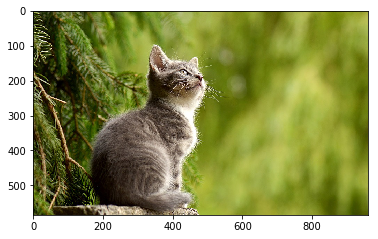

In [34]:
img = Image.open("Cat02.jpg")
plt.imshow(img);

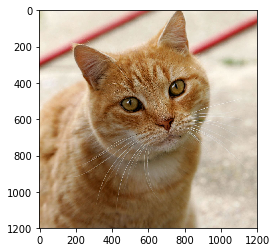

In [35]:
img = Image.open("Cat03.jpg")
plt.imshow(img);

In [63]:
def show_sixteen(images, titles=0):
    f, axarr = plt.subplots(4, 4, figsize=(15, 15), gridspec_kw={"wspace": 0, "hspace": 0})
    for idx, ax in enumerate(f.axes):
        ax.imshow(images[idx])
        ax.axis("off")
        if titles: ax.set_title(titles[idx])
    plt.show()

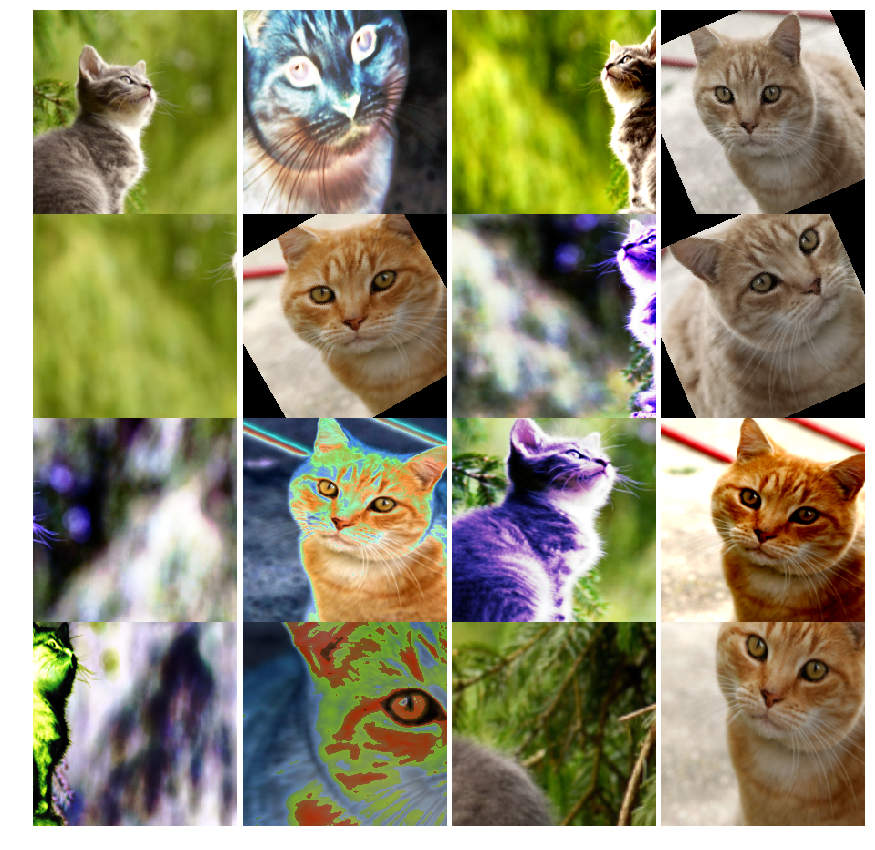

In [64]:
imgs = []
count = 0
for _ in range(10):
    for img in loader:
        img = np.transpose(img[0][0].numpy()*255, (1,2,0)).astype(np.uint8)
        imgs.append(img)
        count += 1
        if count==16: 
            show_sixteen(imgs)
            imgs = []
            count = 0

# What augmentations and ranges are used in ImageNet AutoAugments?

The ImageNet policy is only using 7 out of 16 possible image operations, focusing on color-based transformations and rotations.

In [8]:
ranges = {}
ranges["shearX"] = np.linspace(-0.3, 0.3, 10)
ranges["rotate"] = np.linspace(-30, 30, 10)
ranges["color"] = np.linspace(0.1, 1.9, 10)
ranges["posterize"] = np.round(np.linspace(4, 8, 10), 0).astype(np.int)
ranges["solarize"] = np.linspace(0, 256, 10)
ranges["contrast"] = np.linspace(0.1, 1.9, 10)
ranges["sharpness"] = np.linspace(0.1, 1.9, 10)

In [9]:
img = Image.open("Cat03.jpg")
img = img.resize((300, 300))
# img

## Helper functions

In [10]:
def show_enhanced_and_original(enhanced_img, titles=0):
    f, axarr = plt.subplots(1, 2, figsize=(10, 6))
    axarr[0].imshow(img)
    axarr[0].axis("off")
    axarr[0].set_title(titles[0])
    axarr[1].imshow(enhanced_img)
    axarr[1].axis("off")
    axarr[1].set_title(titles[1])
    plt.show()

def show_three_magnitutes_and_original(images, titles=0):
    f, axarr = plt.subplots(1, 4, figsize=(20, 10))
    for idx, ax in enumerate(axarr):
        if idx==0: ax.imshow(img)
        else: ax.imshow(images[idx-1])
        ax.axis("off")
        if titles: ax.set_title(titles[idx])
    plt.show()

## Augmentations

In [13]:
bla = img.rotate(ranges[enhance_key][0])

In [19]:
bla = np.array(bla)
bla2 = np.array(img)

In [20]:
bla[bla==0].shape

(42271,)

In [18]:
bla2[bla2==0].shape

(509,)

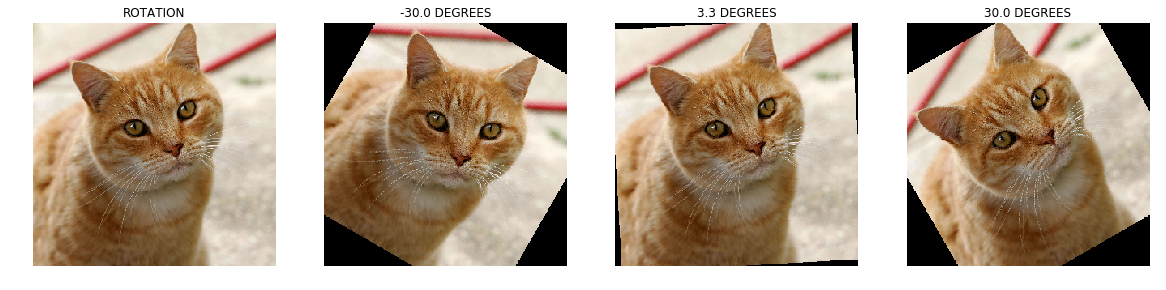

In [12]:
# UNCLEAR: What resampling filter?
enhance_key = "rotate"
show_three_magnitutes_and_original(
    images=[img.rotate(ranges[enhance_key][0]), 
            img.rotate(ranges[enhance_key][5]), 
            img.rotate(ranges[enhance_key][-1])], 
    titles=["ROTATION", "{:.1f} DEGREES".format(ranges[enhance_key][0]), 
            "{:.1f} DEGREES".format(ranges[enhance_key][5]), 
            "{:.1f} DEGREES".format(ranges[enhance_key][-1])])

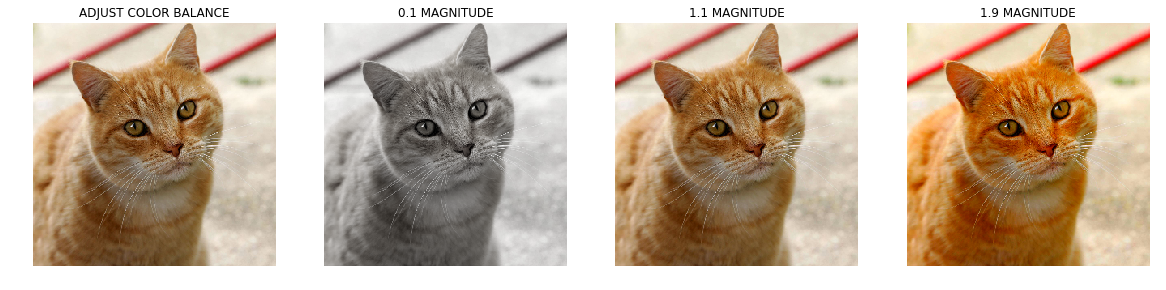

In [126]:
enhance_key = "color"
enhancer = ImageEnhance.Color(img)
show_three_magnitutes_and_original(
    images=[enhancer.enhance(ranges[enhance_key][0]), 
            enhancer.enhance(ranges[enhance_key][5]), 
            enhancer.enhance(ranges[enhance_key][-1])],
    titles=["ADJUST COLOR BALANCE", "{:.1f} MAGNITUDE".format(ranges[enhance_key][0]), 
            "{:.1f} MAGNITUDE".format(ranges[enhance_key][5]), 
            "{:.1f} MAGNITUDE".format(ranges[enhance_key][-1])])

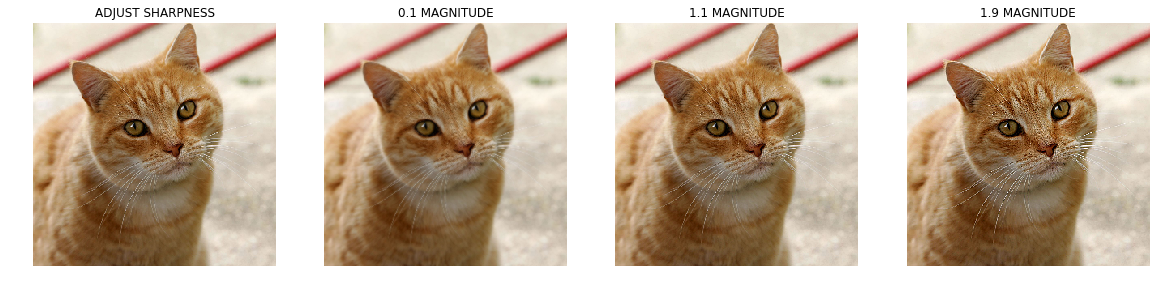

In [127]:
enhance_key = "sharpness"
enhancer = ImageEnhance.Sharpness(img)
show_three_magnitutes_and_original(
    images=[enhancer.enhance(ranges[enhance_key][0]), 
            enhancer.enhance(ranges[enhance_key][5]), 
            enhancer.enhance(ranges[enhance_key][-1])],
    titles=["ADJUST SHARPNESS", "{:.1f} MAGNITUDE".format(ranges[enhance_key][0]),
            "{:.1f} MAGNITUDE".format(ranges[enhance_key][5]), 
            "{:.1f} MAGNITUDE".format(ranges[enhance_key][-1])])

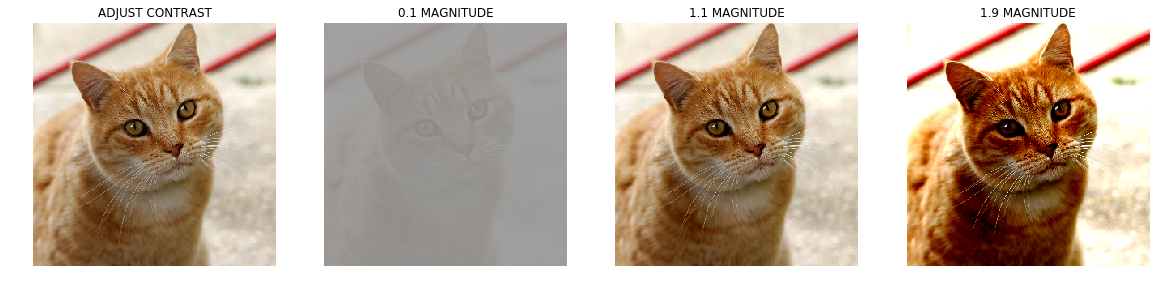

In [128]:
enhance_key = "contrast"
enhancer = ImageEnhance.Contrast(img)
show_three_magnitutes_and_original(
    images=[enhancer.enhance(ranges[enhance_key][0]),
            enhancer.enhance(ranges[enhance_key][5]), 
            enhancer.enhance(ranges[enhance_key][-1])],
    titles=["ADJUST CONTRAST", "{:.1f} MAGNITUDE".format(ranges[enhance_key][0]),
            "{:.1f} MAGNITUDE".format(ranges[enhance_key][5]), 
            "{:.1f} MAGNITUDE".format(ranges[enhance_key][-1])])

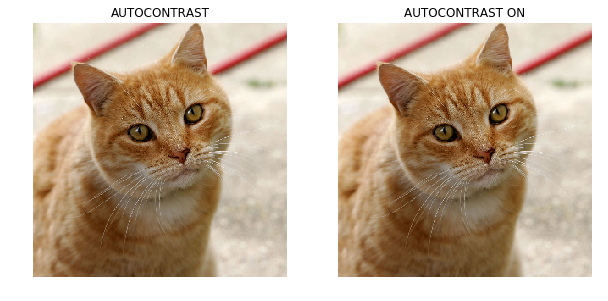

In [115]:
img_enhanced = ImageOps.autocontrast(img) # remaps darkest pixel to 0 and lightest to 255
show_enhanced_and_original(img_enhanced, titles=["AUTOCONTRAST OFF", "AUTOCONTRAST ON"])

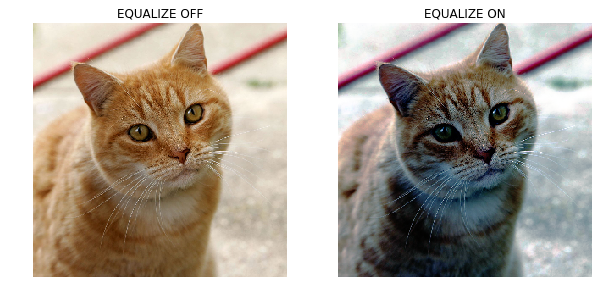

In [116]:
img_enhanced = ImageOps.equalize(img) # equalizes the color histogram
show_enhanced_and_original(img_enhanced, titles=["EQUALIZE OFF", "EQUALIZE ON"])

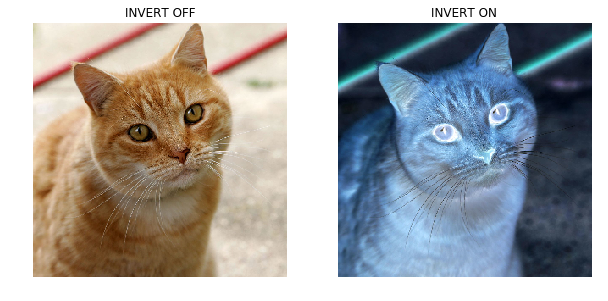

In [117]:
img_enhanced = ImageOps.invert(img) # inverts the pixel values, e.g. 55 --> 200
show_enhanced_and_original(img_enhanced, titles=["INVERT OFF", "INVERT ON"])

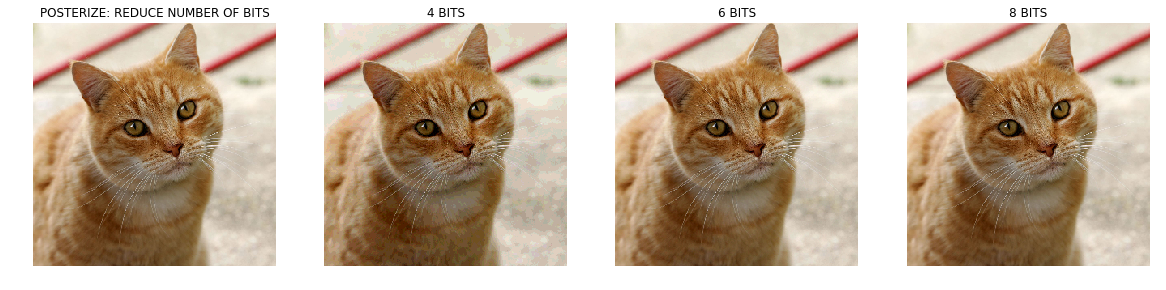

In [129]:
# reduces the number of bits for each color channel
enhance_key = "posterize"
show_three_magnitutes_and_original(
    images=[ImageOps.posterize(img, ranges[enhance_key][0]) ,
            ImageOps.posterize(img, ranges[enhance_key][5]) ,
            ImageOps.posterize(img, ranges[enhance_key][-1])],
    titles=["POSTERIZE: REDUCE NUMBER OF BITS", "{:.0f} BITS".format(ranges[enhance_key][0]),
            "{:.0f} BITS".format(ranges[enhance_key][5]), 
            "{:.0f} BITS".format(ranges[enhance_key][-1])])

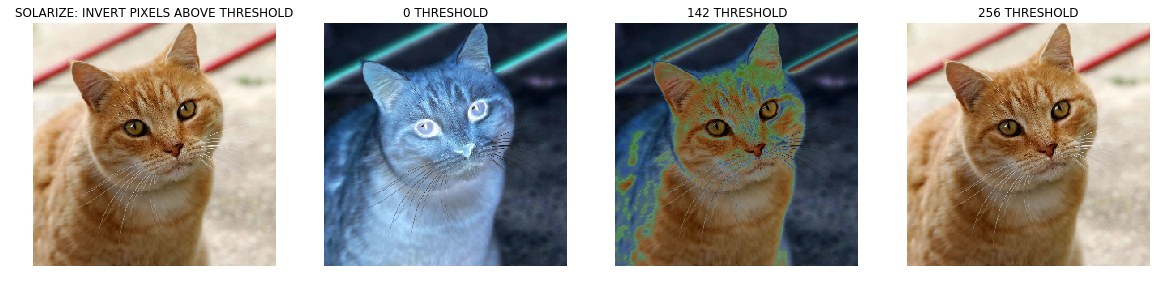

In [120]:
# inverts all pixel values above a threshold
enhance_key = "solarize"
show_three_magnitutes_and_original(
    images=[ImageOps.solarize(img, ranges[enhance_key][0]), 
            ImageOps.solarize(img, ranges[enhance_key][5]), 
            ImageOps.solarize(img, ranges[enhance_key][-1])],
    titles=["SOLARIZE: INVERT PIXELS ABOVE THRESHOLD", 
            "{:.0f} THRESHOLD".format(ranges[enhance_key][0]), 
            "{:.0f} THRESHOLD".format(ranges[enhance_key][5]), 
            "{:.0f} THRESHOLD".format(ranges[enhance_key][-1])])

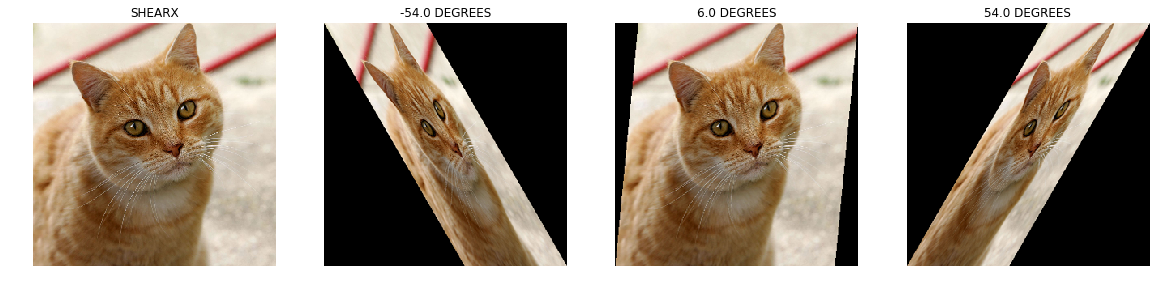

In [121]:
# shear the image along the horizontal axis
enhance_key = "shearX"
show_three_magnitutes_and_original(
    images=[shear(img, ranges[enhance_key][0]*180),
            shear(img, ranges[enhance_key][5]*180),
            shear(img, ranges[enhance_key][-1]*180)],
    titles=["SHEARX", "{:.1f} DEGREES".format(ranges[enhance_key][0]*180),
            "{:.1f} DEGREES".format(ranges[enhance_key][5]*180), 
            "{:.1f} DEGREES".format(ranges[enhance_key][-1]*180)])

## Not used

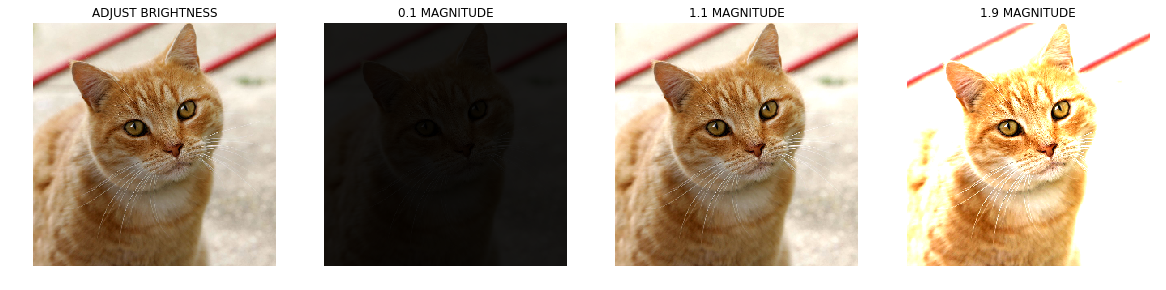

In [122]:
ranges["brightness"] = np.linspace(0.1, 1.9, 10)
# adjust image brightness
enhance_key = "brightness"
enhancer = ImageEnhance.Brightness(img)
show_three_magnitutes_and_original(
    images=[enhancer.enhance(ranges[enhance_key][0]),
            enhancer.enhance(ranges[enhance_key][5]), 
            enhancer.enhance(ranges[enhance_key][-1])],
    titles=["ADJUST BRIGHTNESS", "{:.1f} MAGNITUDE".format(ranges[enhance_key][0]),
            "{:.1f} MAGNITUDE".format(ranges[enhance_key][5]), 
            "{:.1f} MAGNITUDE".format(ranges[enhance_key][-1])])